In [1]:
import torch
import itertools
import numpy as np
import time

from env import GridEnvDeform, POMDPWrapper_v1, create_maze


In [59]:
class Infotaxis():
  
    def __init__(self, T, O, R):
        self.T = T
        self.O = O
        self.R = R
    
    def get_entropy(self, probabilities):
        
        # Calculate entropy, avoiding log(0) by adding a mask
        entropy = -torch.sum(probabilities * torch.log2(probabilities + (probabilities == 0).float()))
        
        return entropy.item()  # .item() to get a standard Python float

    def update_belief(self, belief, action, observation):
        """
        Perform a Bayesian belief update in a POMDP with action-dependent transition and observation models.

        Parameters:
            belief (torch.Tensor): Initial belief distribution over states, shape (num_states,)
            action (int): The action taken (index of action)
            observation (int): The observation received (index of observation)
            T (torch.Tensor): Transition probabilities, shape (num_states, num_actions, num_states)
            O (torch.Tensor): Observation probabilities, shape (num_states, num_actions, num_observations)

        Returns:
            torch.Tensor: The updated belief over states, shape (num_states,)

            P(s'|b,a,o) = \eta * P(o|s',a) sum_s P(s'|s,a)b(s) = \eta P(o|s',a) P(s'|b,a) 
        """
        # Prediction Step: Compute predicted belief over next states
        predicted_belief = torch.matmul(belief, self.T[:, action])

        # Update Step: Multiply by observation likelihood
        observation_likelihood = self.O[:, action, observation]
        new_belief = predicted_belief * observation_likelihood

        # Normalize the updated belief to ensure it's a valid probability distribution
        if new_belief.sum() > 0:
            new_belief /= new_belief.sum() 
                
        return new_belief
    
    def update_belief_superbatched(self, belief):
        """
        Perform a Bayesian belief update in a POMDP with action-dependent transition and observation models.

        Parameters:
            belief (torch.Tensor): Initial belief distribution over states, shape (num_states,)
            action (int): The action taken (index of action)
            observation (int): The observation received (index of observation)
            T (torch.Tensor): Transition probabilities, shape (num_states, num_actions, num_states)
            O (torch.Tensor): Observation probabilities, shape (num_states, num_actions, num_observations)

        Returns:
            torch.Tensor: The updated belief over states, shape (num_states,)
        """
        # Prediction Step: Compute predicted belief over next states
        # [predicted_belief]_a,s' = sum_s P(s'|s,a) * [belief]_s
        predicted_belief = torch.einsum('s,san->an', belief, self.T)

        # Update Step: Multiply by observation likelihood
        new_belief = torch.einsum('as,sao->sao', predicted_belief, self.O)


        # Normalize the updated belief to ensure it's a valid probability distribution
        new_belief /= new_belief.sum(dim=0) + 1e-10
                
        return new_belief

    def G(self,b,a=None):
        """"
        
        input:
        b: belief
        a: action

        output: 
        G: torch.tensor shape (numactions) expected reduction of the belief's entropy G (b, a)
        
        
        G(b,a) = H(b) - sum_o P(o|b,a)H(b|a,o)
        P(o|b,a) = sum_s P(o|s,a)P(s|b,a) = sum_s P(o|s,a) sum_s' P(s|s',a)P(s'|b)
        
        """
        # H(b) = entropy of belief
        H_b = self.get_entropy(b)
        
        # [P_o_b_a]_o_a = P(o|b,a) = sum_s P(o|s,a)P(s|b,a) = sum_s P(o|s,a) sum_s' P(s|s',a)b(s') shape (numobservations,numactions)
        P_o_b_a = torch.einsum('sao,nas,n->oa',self.O,self.T,b)

        # [bprime]_s_a_o = P(s|b,a,o) shape (numstates, numactions, numobservations)
        brpime = self.update_belief_superbatched(b)

        # [H_b_a_o]_i = H(b|a,o_i) = entropy of updated belief shape (numactions, numobservations)
        H_b_a_o = - torch.sum(brpime * torch.log2(brpime + (brpime == 0).float()), dim=0)

        G = H_b - torch.einsum('oa,ao->a', P_o_b_a, H_b_a_o)

        if a is not None:
            return G[a]
        
        return G

    def get_action(self, belief):
        """
        Compute the action that minimizes the expected entropy of the belief.

        Parameters:
            belief (torch.Tensor): The current belief over states, shape (num_states,)

        Returns:
            int: The action that minimizes the expected entropy of the belief
        """
        # Compute the expected entropy reduction for each action
        G = self.G(belief)
        
        # Return the action that minimizes the expected entropy
        return torch.argmax(G).item()
        

In [60]:
O = torch.load('./models/O_maze_2.pt', weights_only=True)
T = torch.load('./models/T_maze_2.pt', weights_only=True)
R = torch.load('./models/R_maze_2.pt', weights_only=True)

Infotaxis = Infotaxis(T,O,R)

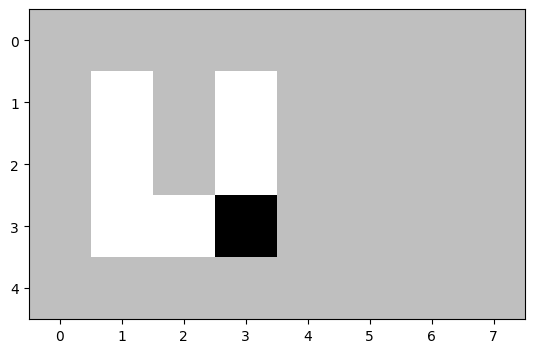

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]



In [61]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")

T = torch.load(f"models/T_maze_{N}.pt", weights_only=True)
R = torch.load(f"models/R_maze_{N}.pt", weights_only=True)
O = torch.load(f"models/O_maze_{N}.pt", weights_only=True)


In [62]:
env_wrapper = POMDPWrapper_v1(env, T,O,R)

Initial state:  ((1, 4, 1), (2, 1))


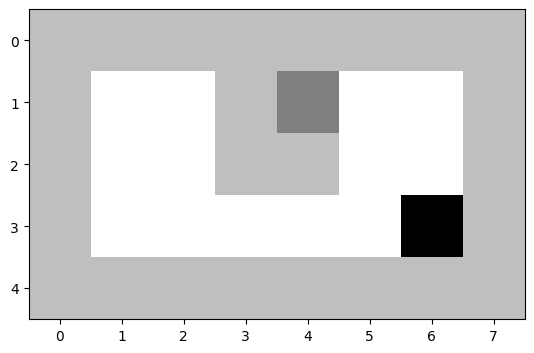

Best action:  0
state 27


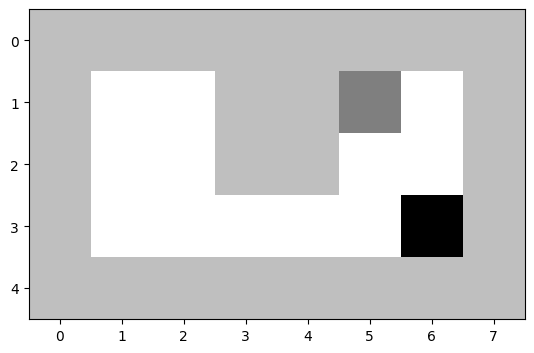

Step:  9
Timestep missing: 9  
Total reward:     -0.5  
Chosen action:  0
Actual State:  ((1, 5, 1), (2, 1))
argmax and max Belief:  ((1, 5, 1), (2, 1)) tensor(0.2000)
Belief entropy:  2.321928024291992
Best action:  1
state 35


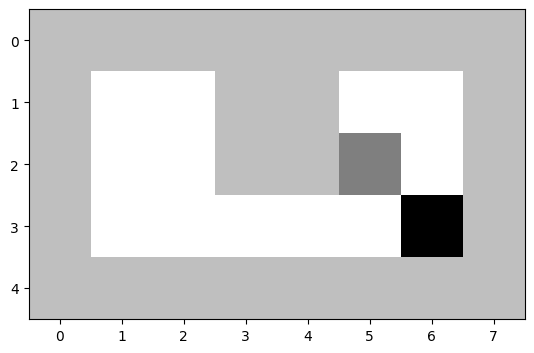

Step:  8
Timestep missing: 8  
Total reward:     -1.0  
Chosen action:  1
Actual State:  ((2, 5, 2), (2, 1))
argmax and max Belief:  ((2, 5, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 85


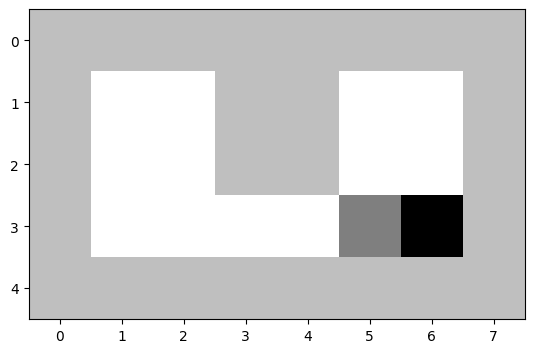

Step:  7
Timestep missing: 7  
Total reward:     -1.5  
Chosen action:  0
Actual State:  ((3, 5, 2), (2, 1))
argmax and max Belief:  ((3, 5, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 133


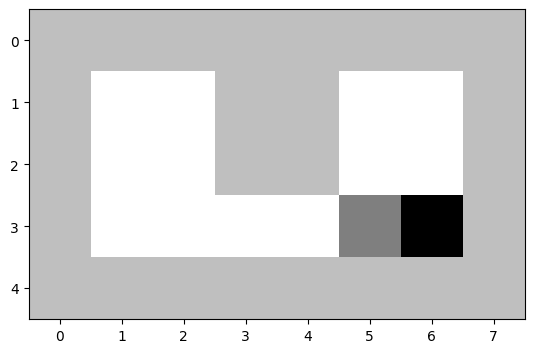

Step:  6
Timestep missing: 6  
Total reward:     -2.5  
Chosen action:  0
Actual State:  ((3, 5, 2), (2, 1))
argmax and max Belief:  ((3, 5, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 133


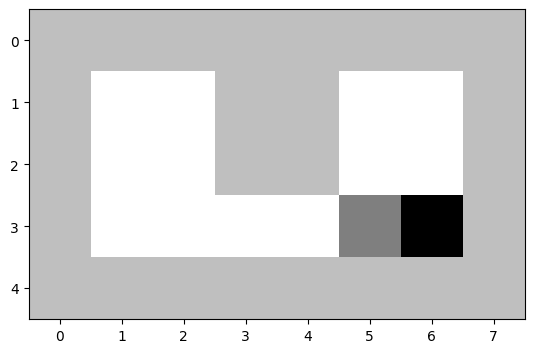

Step:  5
Timestep missing: 5  
Total reward:     -3.5  
Chosen action:  0
Actual State:  ((3, 5, 2), (2, 1))
argmax and max Belief:  ((3, 5, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 133


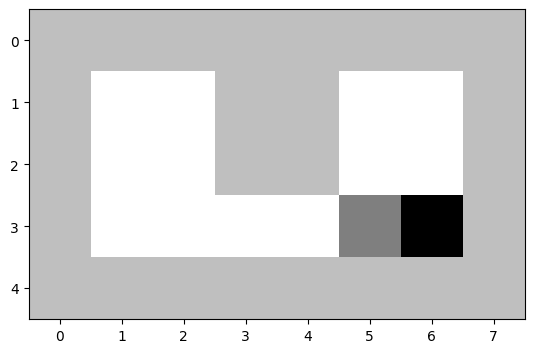

Step:  4
Timestep missing: 4  
Total reward:     -4.5  
Chosen action:  0
Actual State:  ((3, 5, 2), (2, 1))
argmax and max Belief:  ((3, 5, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 133


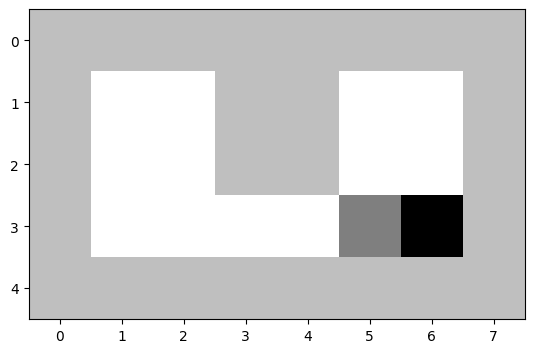

Step:  3
Timestep missing: 3  
Total reward:     -5.5  
Chosen action:  0
Actual State:  ((3, 5, 2), (2, 1))
argmax and max Belief:  ((3, 5, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 133


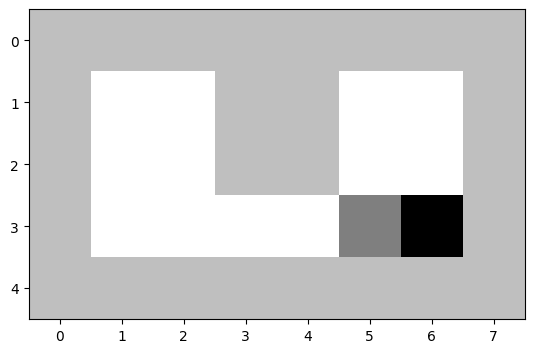

Step:  2
Timestep missing: 2  
Total reward:     -6.5  
Chosen action:  0
Actual State:  ((3, 5, 2), (2, 1))
argmax and max Belief:  ((3, 5, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0
Best action:  0
state 133


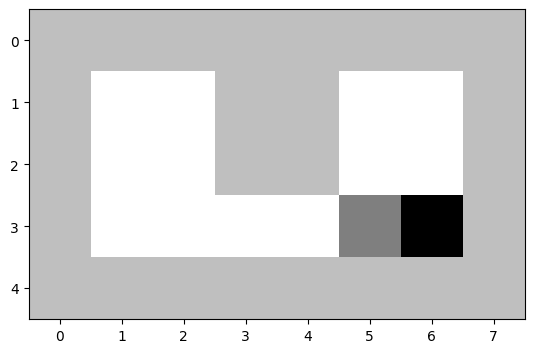

Step:  1
Timestep missing: 1  
Total reward:     -7.5  
Chosen action:  0
Actual State:  ((3, 5, 2), (2, 1))
argmax and max Belief:  ((3, 5, 2), (2, 1)) tensor(1.)
Belief entropy:  -0.0


KeyboardInterrupt: 

In [87]:
# the simulation starts with given belief and random state
b = torch.ones(len(states)) / len(states)
s = np.random.randint(len(states))

print("Initial state: ", states[s])
env.render(states[s])

horizon = 10
totalReward = 0.0

for t in range(horizon - 1, -1, -1):

    best_action = Infotaxis.get_action(b)

    #best_action = np.random.choice([0,1,2,3])
    print("Best action: ", best_action)
    print("state", s)
    next_obs, reward, done, info = env_wrapper.step(s, best_action)
    
    next_state = info['actual_state']
    env.render(states[next_state])


    totalReward += reward
    next_belief = env_wrapper.update_belief(b, best_action, next_obs)
    
    print("Step: ", t)
    print("Timestep missing: " + str(t) + "  ") # Print space after to clear
    print("Total reward:     " + str(totalReward) + "  ")
    print("Chosen action: ", best_action)

    print("Actual State: ", states[next_state])
    print("argmax and max Belief: ", states[torch.argmax(next_belief)], torch.max(next_belief))
    print("Belief entropy: ", Infotaxis.get_entropy(next_belief))

    if t == 1:
        assert states[torch.argmax(next_belief)] == states[next_state] 
    
    # Then we update the world
    s = next_state
    b = next_belief
    # Sleep 1 second so the user can see what is happening.
    time.sleep(1)

